### Grafico la curva de abundance matching

/tmp/ipykernel_52875/3018449152.py:166: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend2 = ax.legend([lines[i] for i in range(12,20)],[lines[i].get_label() for i in range(12,20)],frameon=False, fontsize=15,loc=2)


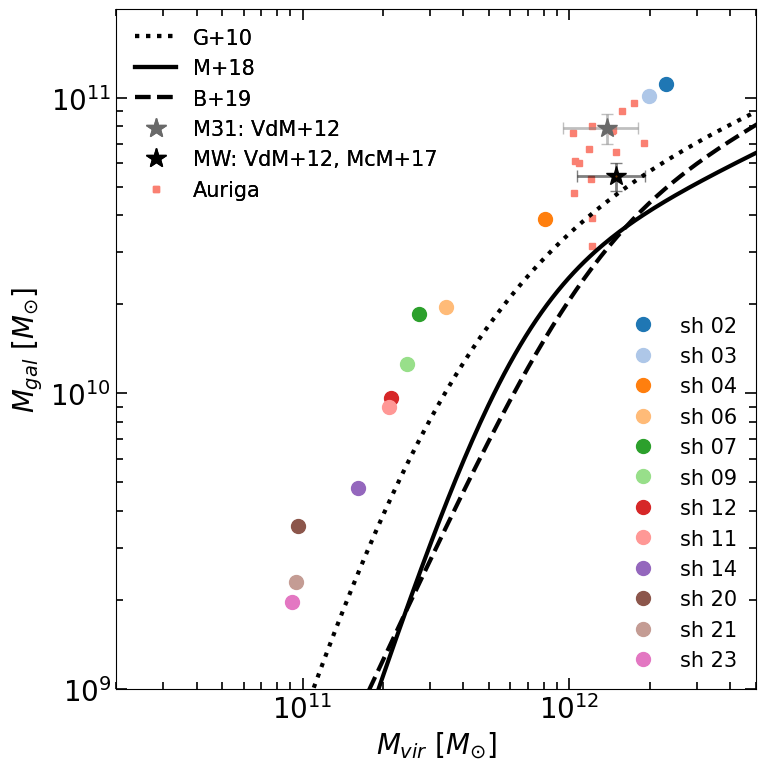

In [4]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import gc
import time_conversion as time
import random

G = 4.299e-6

#-----------------CURVA DE GOU-----------------------------
c = 0.129
M0 = 10**11.4
alpha = 0.926
beta = 0.261
gamma = 2.440
M_vir = 10**np.linspace(10,13,300)

c1 = (M_vir/M0)**(-alpha)
c2 = (M_vir/M0)**beta
M_estrella = M_vir * c * ((c1+c2)**(-gamma))

Me=np.log10(M_estrella)

#-------fraccion de bariones universal--------------------
MM1 = np.arange(10.5, 13, 0.05)
fbar = 0.0418/0.24
Mbar = fbar * 10**MM1


#_________________________________Moster
N = 0.137
M1 = 10**11.79
Beta = 1.76
gamma = 0.568

M_most_z0 = 10**np.linspace(10,13,300)
m_most_z0 = M_most_z0 * 0.157 * 2 * N *( (M_most_z0/M1)**(-Beta) + (M_most_z0/M1)**gamma )**(-1)

#_________________________________Behroozi
epsi = -1.431
M1 = 10**12.074
alfa = 1.974
Beta = 0.470
delta = 0.382
gamma = 10**(-1.160)

M_behr_z0 = 10**np.linspace(10,13,300)
x  = np.log10(M_behr_z0 / M1)
fx = epsi-np.log10(10**(-alfa*x) + 10**(-Beta*x)) + gamma* np.exp(-0.5*((x/delta)**2))        
m_behr_z0= 10**(fx) * M1
#--------------------------------------------------

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.subplots_adjust(bottom=0.10, left =0.15, right = 0.95, top = 0.95,hspace=0.05)

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

colors = plt.cm.tab20(np.linspace(0, 1, 19))

for j in range(12):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]
    Mvir = snap['/M200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    sft  = snap['/Str/FormationTime'][()]

    pgas = snap['/Gas/Coordinates'][()]
    mgas = snap['/Gas/Masses'][()]

    pdrk = snap['/Drk/Coordinates'][()]
    mdrk = snap['/Drk/Masses'][()]

    amask, = np.where(sft>0)#aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    emask, = np.where(sft<0)
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = pgas[:,0]*aexp/h
    ygas = pgas[:,1]*aexp/h
    zgas = pgas[:,2]*aexp/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = pdrk[:,0]*aexp/h
    ydrk = pdrk[:,1]*aexp/h
    zdrk = pdrk[:,2]*aexp/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h
    M200 = Mvir/h
    
    R200 = Rvir*aexp/h
    rgal = 0.15*R200

    limit_str   = np.where(rstr<rgal)
    Mstr = np.sum(mstr[limit_str])
   
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot, = np.where(rtot<R200)
    Mtot = np.sum(mtot[limit_tot])
    
    # print(ID[j], '{:e}'.format(M200), '{:e}'.format(Mtot), '{:e}'.format(Mstr), R200, rgal)
#---------------------------------------------------------
    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
    
    ax.plot(Mtot, Mstr,'o',markersize = 10, label='sh '+ Id, color=colors[j])
    # ax2.plot(R200, M200, 'o',markersize = 10, label='sh '+ Id)
    # ax3.plot(Mtot,np.log10(M200/Mtot), 'o',markersize = 10, label='sh '+ Id)
                   
ax.plot(M_vir, M_estrella, ':', color='k', lw=3, label='G+10')
ax.plot(M_most_z0, m_most_z0,'-', color='k', lw=3, label='M+18')
ax.plot(M_behr_z0, m_behr_z0, '--', color='k', lw=3,label='B+19')
ax.plot(1.38e12,7.90e10,'*',color='dimgray',ms=15,label='M31: VdM+12')
ax.plot(1.50e12,5.43e10,'*',color='k',ms=15,label='MW: VdM+12, McM+17')
ax.plot(1e9, 1e11, 's',ms=5,color='salmon', label ='Auriga',zorder=1)
ax.plot(Mvir_Au, Mgal_Au, 's',ms=5,color='salmon',zorder=1)    
ax.errorbar(1.38e12,7.90e10, xerr =0.43e12, yerr=0.9e10, ecolor='gray',
            alpha=0.5, elinewidth=2, fmt='.',markersize=1, 
            capsize=4, zorder=1)
ax.errorbar(1.50e12,5.43e10, xerr =0.43e12, yerr=0.6e10, ecolor='k',
            alpha=0.5, elinewidth=2, fmt='.',markersize=1, 
            capsize=4, zorder=2)

# ax.plot(1e11,1e10,'+','r',ms=18)
# ax.text(1e11,1.1e10, r'($\leftarrow$425532,497512$\downarrow$)',fontsize=15,ha='center')

# ax.plot(MM1, np.log10(Mbar),'--', lw=1, color ='k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e9,10**11.3)
ax.set_xlim(10**10.3,10**12.7)
ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax.set_xlabel(r'$M_{vir}$ $[M_{\odot}]$', fontsize=20)
ax.set_ylabel(r'$M_{gal}$ $[M_{\odot}]$', fontsize=20)
# ax.text(11.1,10.42, r'$f_{bar} \times M_{vir}$', rotation=39, fontsize=18)
# ax.text(12,10.45, 'Guo et al. 2010', rotation=28, fontsize=18)
lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in range(12)],[lines[i].get_label() for i in range(12)],frameon=False, fontsize=15,loc=4)
ax.add_artist(legend1)
legend2 = ax.legend([lines[i] for i in range(12,20)],[lines[i].get_label() for i in range(12,20)],frameon=False, fontsize=15,loc=2)
ax.add_artist(legend2)

fig.savefig('../_imagenes/Mvir_vs_Mgal_2.png', dpi = 100)
plt.show()

#### Auriga data


In [2]:
import numpy as np
Mvir_Au = np.array([1.91,1.46,1.19,1.04,1.05,1.09,1.22,1.50,1.03,1.22,1.21,1.45,1.58,1.49,1.22,1.75])*1e12
Mgal_Au = np.array([7.05,7.75,6.72,4.75,6.10,6.01,3.93,5.41,7.61,8.04,5.32,7.72,9.02,6.55,3.14,9.61])*1e10

127000000000002.0 2.299188e+12 2.308925e+12 1.116459e+11 278.1909399439279 41.72864099158918
127000000000003.0 1.959436e+12 1.991354e+12 1.012675e+11 263.7597757119668 39.56396635679502
127000000000004.0 8.102051e+11 8.101241e+11 3.902301e+10 196.4881215877231 29.473218238158463
127000000000006.0 3.449786e+11 3.447765e+11 1.960704e+10 147.8235207318872 22.17352810978308
127000000000007.0 2.721499e+11 2.719804e+11 1.850878e+10 136.5943632875903 20.489154493138546
127000000000009.0 2.432581e+11 2.460419e+11 1.254914e+10 131.57739412719488 19.73660911907923
127000000000012.0 2.139575e+11 2.136722e+11 9.620083e+09 126.05872805075988 18.90880920761398
127000000000011.0 2.117146e+11 2.115832e+11 9.009487e+09 125.6160543013132 18.84240814519698
127000000000014.0 1.585598e+11 1.614366e+11 4.804037e+09 114.07702523240368 17.11155378486055
127000000000020.0 9.662786e+10 9.606486e+10 3.556135e+09 96.72421425409469 14.508632138114203
127000000000021.0 9.458817e+10 9.447194e+10 2.299720e+09 96.0306

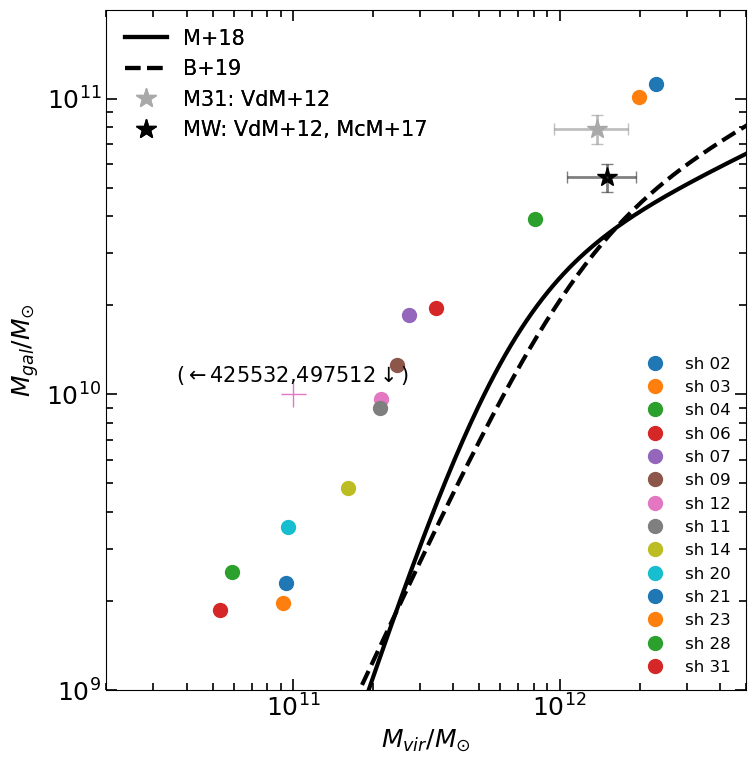

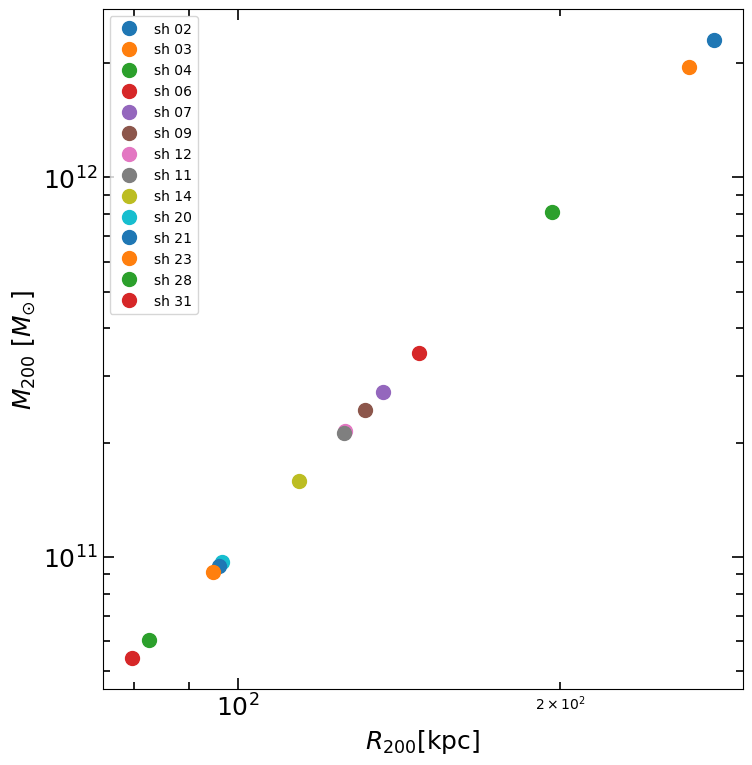

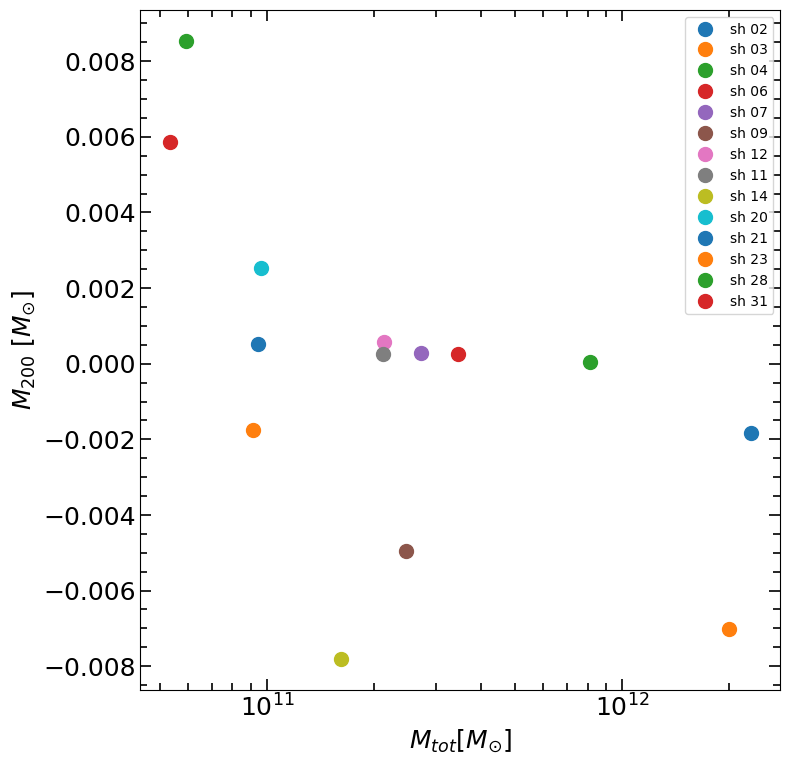

In [3]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import gc
import time_conversion as time
import random

G = 4.299e-6

#-----------------CURVA DE GOU-----------------------------
c = 0.129
M0 = 10**11.4
alpha = 0.926
beta = 0.261
gamma = 2.440
MM = np.linspace(11,13,300)
M_vir = 10**MM

#------------------curva de Guo et al 2010-------------------
c1 = (M_vir/M0)**(-alpha)
c2 = (M_vir/M0)**beta
M_estrella = M_vir * c * ((c1+c2)**(-gamma))

Me=np.log10(M_estrella)

#-------fraccion de bariones universal--------------------
MM1 = np.arange(10.5, 13, 0.05)
fbar = 0.0418/0.24
Mbar = fbar * 10**MM1


#_________________________________Moster
N = 0.137
M1 = 10**11.79
Beta = 1.76
gamma = 0.568

M_most_z0 = 10**np.linspace(10,13,300)
m_most_z0 = M_most_z0 * 0.157 * 2 * N *( (M_most_z0/M1)**(-Beta) + (M_most_z0/M1)**gamma )**(-1)

#_________________________________Behroozi
epsi = -1.431
M1 = 10**12.074
alfa = 1.974
Beta = 0.470
delta = 0.382
gamma = 10**(-1.160)

M_behr_z0 = 10**np.linspace(10,13,300)
x  = np.log10(M_behr_z0 / M1)
fx = epsi-np.log10(10**(-alfa*x) + 10**(-Beta*x)) + gamma* np.exp(-0.5*((x/delta)**2))        
m_behr_z0= 10**(fx) * M1
#--------------------------------------------------

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig.subplots_adjust(bottom=0.10, left =0.15, right = 0.95, top = 0.95,hspace=0.05)

fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig2.subplots_adjust(bottom=0.10, left =0.15, right = 0.95, top = 0.95,hspace=0.05)

fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig3.subplots_adjust(bottom=0.10, left =0.15, right = 0.95, top = 0.95,hspace=0.05)

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for j in range(14):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]
    Mvir = snap['/M200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    sft  = snap['/Str/FormationTime'][()]

    pgas = snap['/Gas/Coordinates'][()]
    mgas = snap['/Gas/Masses'][()]

    pdrk = snap['/Drk/Coordinates'][()]
    mdrk = snap['/Drk/Masses'][()]

    amask, = np.where(sft>0)#aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    emask, = np.where(sft<0)
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = pgas[:,0]*aexp/h
    ygas = pgas[:,1]*aexp/h
    zgas = pgas[:,2]*aexp/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = pdrk[:,0]*aexp/h
    ydrk = pdrk[:,1]*aexp/h
    zdrk = pdrk[:,2]*aexp/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h
    M200 = Mvir/h
    
    R200 = Rvir*aexp/h
    rgal = 0.15*R200

    limit_str   = np.where(rstr<rgal)
    Mstr = np.sum(mstr[limit_str])
   
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot, = np.where(rtot<R200)
    Mtot = np.sum(mtot[limit_tot])
    
    print(ID[j], '{:e}'.format(M200), '{:e}'.format(Mtot), '{:e}'.format(Mstr), R200, rgal)
#---------------------------------------------------------
    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
    
    ax.plot(Mtot, Mstr,'o',markersize = 10, label='sh '+ Id)
    ax2.plot(R200, M200, 'o',markersize = 10, label='sh '+ Id)
    ax3.plot(Mtot,np.log10(M200/Mtot), 'o',markersize = 10, label='sh '+ Id)
                     
    
# ax.plot(MM, Me, ':', color='b', lw=10, label='Guo +10')
ax.plot(M_most_z0, m_most_z0,'-', color='k', lw=3, label='M+18')
ax.plot(M_behr_z0, m_behr_z0, '--', color='k', lw=3,label='B+19')
ax.plot(1.38e12,7.90e10,'*',color='darkgray',ms=15,label='M31: VdM+12')
ax.plot(1.50e12,5.43e10,'*',color='k',ms=15,label='MW: VdM+12, McM+17')
ax.errorbar(1.38e12,7.90e10, xerr =0.43e12, yerr=0.9e10, ecolor='gray',
            alpha=0.5, elinewidth=2, fmt='.',markersize=1, 
            capsize=4, zorder=1)
ax.errorbar(1.50e12,5.43e10, xerr =0.43e12, yerr=0.6e10, ecolor='k',
            alpha=0.5, elinewidth=2, fmt='.',markersize=1, 
            capsize=4, zorder=2)
ax.plot(1e11,1e10,'+','r',ms=18)
ax.text(1e11,1.1e10, r'($\leftarrow$425532,497512$\downarrow$)',fontsize=15,ha='center')

# ax.plot(MM1, np.log10(Mbar),'--', lw=1, color ='k')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e9,10**11.3)
ax.set_xlim(10**10.3,10**12.7)
ax.minorticks_on()
ax.tick_params( labelsize=18)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax.set_xlabel(r'$M_{vir}/M_{\odot}$', fontsize=18)
ax.set_ylabel(r'$M_{gal}/M_{\odot}$', fontsize=18)
# ax.text(11.1,10.42, r'$f_{bar} \times M_{vir}$', rotation=39, fontsize=18)
# ax.text(12,10.45, 'Guo et al. 2010', rotation=28, fontsize=18)
lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in range(14)],[lines[i].get_label() for i in range(14)],frameon=False, fontsize=12,loc=4)
ax.add_artist(legend1)
legend2 = ax.legend([lines[i] for i in range(14,18)],[lines[i].get_label() for i in range(14,18)],frameon=False, fontsize=15,loc=2)
ax.add_artist(legend2)

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.minorticks_on()
ax2.tick_params( labelsize=18)
ax2.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax2.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax2.set_ylabel(r'$M_{200}$ [$M_{\odot}$]', fontsize=18)
ax2.set_xlabel(r'$R_{200}$[kpc]', fontsize=18)
ax2.legend()
                     
# ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.minorticks_on()
ax3.tick_params( labelsize=18)
ax3.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax3.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax3.set_ylabel(r'$M_{200}$ [$M_{\odot}$]', fontsize=18)
ax3.set_xlabel(r'$M_{tot}$[$M_{\odot}$]', fontsize=18)
ax3.legend()

fig.savefig('../_imagenes/Mvir_vs_Mgal.png', dpi = 100)
plt.show()

### Veo que las masas del AHF sean similar a las calculadas dentro de Rvir

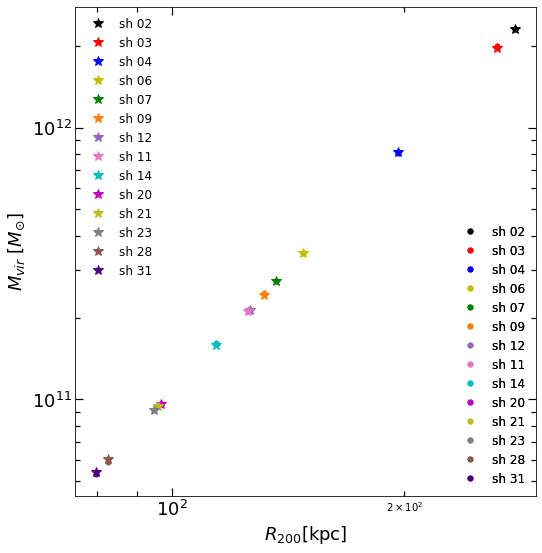

In [11]:
import numpy as np
path = '/store/clues/HESTIA/RE_SIMS/8192/GAL_FOR/17_11/AHF_output_2x2.5Mpc/'
data = np.loadtxt(path + 'HESTIA_100Mpc_8192_17_11.127.z0.000.AHF_halos')

ID   = data[:,0]
Mvir = data[:,3]
Xc   = data[:,5]
Yc   = data[:,6]
Zc   = data[:,7]
Rvir = data[:,11]
fMhires = data[:,37]

hires = np.where(fMhires > 0.9999)
IDs   = ID[hires]
M_vir = Mvir[hires]
X_c   = Xc[hires]
Y_c   = Yc[hires]
Z_c   = Zc[hires]
R_vir = Rvir[hires]

mask = np.argsort(M_vir)

MVir_AHF = M_vir[mask][::-1]
RVir_AHF = R_vir[mask][::-1]
Id_AHF   = IDs[mask][::-1]

import matplotlib.pyplot as plt
import h5py
import time_conversion as time

G = 4.299e-6

fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
fig2.subplots_adjust(bottom=0.10, left =0.15, right = 0.95, top = 0.95,hspace=0.05)

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'
color = ('k','r','b','y','g','tab:orange','tab:purple','tab:pink','c','m','tab:olive','tab:gray','tab:brown','indigo','lime')

for j in range(14):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    sft  = snap['/Str/FormationTime'][()]

    pgas = snap['/Gas/Coordinates'][()]
    mgas = snap['/Gas/Masses'][()]

    pdrk = snap['/Drk/Coordinates'][()]
    mdrk = snap['/Drk/Masses'][()]

    amask, = np.where(sft>0)#aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    emask, = np.where(sft<0)
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = pgas[:,0]*aexp/h
    ygas = pgas[:,1]*aexp/h
    zgas = pgas[:,2]*aexp/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = pdrk[:,0]*aexp/h
    ydrk = pdrk[:,1]*aexp/h
    zdrk = pdrk[:,2]*aexp/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h
    
    R200 = Rvir*aexp/h
    rgal = 0.15*R200

    limit_str   = np.where(rstr<rgal)
    Mstr = np.sum(mstr[limit_str])
   
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<R200)
    Mtot = np.sum(mtot[limit_tot])
#---------------------------------------------------------
    Id = ''
    IDAHF = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
    for aux2 in list(str('%d'%Id_AHF[j]))[-2:]:
        IDAHF += aux2
    
    ax2.plot(RVir_AHF[j]*aexp/h,MVir_AHF[j]/h,'*',ms=10,label = 'sh '+ IDAHF, color=color[j])
    ax2.plot(R200, Mtot, 'o',markersize = 5, label='sh '+ Id, color=color[j])

    
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.minorticks_on()
ax2.tick_params( labelsize=18)
ax2.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
ax2.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
ax2.set_ylabel(r'$M_{vir}$ [$M_{\odot}$]', fontsize=18)
ax2.set_xlabel(r'$R_{200}$[kpc]', fontsize=18)
lines = ax2.get_lines()
legend1 = ax2.legend([lines[i] for i in range(0,28,2)],[lines[i].get_label() for i in range(0,28,2)],frameon=False, fontsize=12,loc=2)
ax2.add_artist(legend1)
legend2 = ax2.legend([lines[i] for i in range(1,28,2)],[lines[i].get_label() for i in range(1,28,2)],frameon=False, fontsize=12,loc=4)
ax2.add_artist(legend2)

plt.show()


#### Checkeo cuanta masa de particulas con tiempo de formacion<0 hay 

In [6]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import gc
import time_conversion as time
import random

G = 4.299e-6

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127/'

for j in range(15):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')
    print('subhalo', str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    sft  = snap['/Str/FormationTime'][()]

    pgas = snap['/Gas/Coordinates'][()]
    mgas = snap['/Gas/Masses'][()]

    pdrk = snap['/Drk/Coordinates'][()]
    mdrk = snap['/Drk/Masses'][()]

    amask, = np.where(sft>0)#aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    emask, = np.where(sft<0)
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]*aexp/h
    ystr = pstr[:,1]*aexp/h
    zstr = pstr[:,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
    
    mstr = mstr*1e10/h

    xgas = pgas[:,0]*aexp/h
    ygas = pgas[:,1]*aexp/h
    zgas = pgas[:,2]*aexp/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = pdrk[:,0]*aexp/h
    ydrk = pdrk[:,1]*aexp/h
    zdrk = pdrk[:,2]*aexp/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
    #----------------------masas----------------------------
    
    R200 = Rvir*aexp/h
    limit, = np.where(rstr<R200)
    
    Mass_total = np.sum(mstr[limit])
    print('Total', '%1.2e'%Mass_total)
    
    limit2, = np.where(rstr[amask]<R200)
    Mass_recortada = np.sum(mstr[amask][limit2])
    print('Recortada', '%1.2e'%Mass_recortada)
    print('Cociente', Mass_recortada/Mass_total)
    print('-----------------------')
    
    

subhalo 127000000000002
Total 1.31e+11
Recortada 1.29e+11
Cociente 0.98425967
-----------------------
subhalo 127000000000003
Total 1.18e+11
Recortada 1.18e+11
Cociente 0.99729943
-----------------------
subhalo 127000000000004
Total 4.46e+10
Recortada 4.42e+10
Cociente 0.9900758
-----------------------
subhalo 127000000000006
Total 2.03e+10
Recortada 2.00e+10
Cociente 0.98691523
-----------------------
subhalo 127000000000007
Total 1.92e+10
Recortada 1.90e+10
Cociente 0.9852896
-----------------------
subhalo 127000000000009
Total 1.33e+10
Recortada 1.31e+10
Cociente 0.9860973
-----------------------
subhalo 127000000000012
Total 1.04e+10
Recortada 9.93e+09
Cociente 0.95538265
-----------------------
subhalo 127000000000011
Total 1.01e+10
Recortada 9.64e+09
Cociente 0.9553974
-----------------------
subhalo 127000000000014
Total 6.96e+09
Recortada 6.17e+09
Cociente 0.88596964
-----------------------
subhalo 127000000000020
Total 4.42e+09
Recortada 3.78e+09
Cociente 0.8558143
---------